In [11]:
import pandas as pd
import numpy as np
import os, json, re, glob
from os.path import join
from netneurotools import datasets as nntdata
from neuromaps.parcellate import Parcellater

from nilearn import image, plotting
from surfplot import Plot

from neuromaps.datasets import fetch_fslr
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti



# gradient color bar
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
import seaborn as sns

## functin: gradient color bar

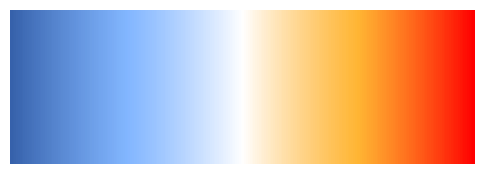

In [12]:
# Define the colors at specific points
colors = [
    (-1.8, "#120041"),  # Start with blue at -1.9
    (-1.2, "#2500fa"),
    (-0.6, "#84c6fd"),  # Start with blue at -1.9
    (0, "white"),    # Transition to white at 0
    (0.4, "#d50044"),
    (0.8, "#ff0000"),    # Start transitioning to red just after 0 towards 1.2
    (1.2, "#ffd400")  # End with yellow at 1.2
]

colors_with_opacity = [
    (-1.8, to_rgba("#3661ab", alpha=1.0)),  # Fully opaque
    (-0.9, to_rgba("#63a4ff", alpha=0.8)),  # Fully opaque
    # (-0.1, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0, to_rgba("white", alpha=1.0)),       # Fully opaque
    # (0.1, to_rgba("#d50044", alpha=0.6)),   # 30% opacity
    (0.6, to_rgba("#ffa300", alpha=0.8)),   # 60% opacity
    (1.2, to_rgba("#ff0000", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(-1.9, 1.2, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()

plt.show()


# gradient


# function for brain plot

In [13]:
# %%


def plot_brain_surfaces(image, cbar_label='INSERT LABEL', cmap='viridis', color_range=None):
    """
    Plot brain surfaces with the given data.

    Parameters:
    - TST: Tuple of (left hemisphere data, right hemisphere data) to be plotted.
    - cbar_label: Label for the color bar.
    - cmap: Colormap for the data.
    - color_range: Optional. Tuple of (min, max) values for the color range. If not provided, the range is auto-detected.
    """
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']
    
    p = Plot(surf_lh=lh_fslr,
             surf_rh=rh_fslr, 
             size=(1000, 200), 
             zoom=1.2, layout='row', 
             views=['lateral', 'medial', 'ventral', 'posterior'], 
             mirror_views=True, brightness=.7)
    p.add_layer({'left': image[0], 
            'right': image[1]}, 
            cmap=cmap, cbar=True,
            color_range=color_range,
            cbar_label=cbar_label
            ) # YlOrRd_r

    cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
    fig = p.build(cbar_kws=cbar_kws)
    return(fig)
    # fig.show()


In [21]:
# stack data
xcorr_dir = '/Volumes/spacetop_projects_cue/analysis/physio/xcorr'

# directory = 'path/to/your/files'
all_frames = []  # List to hold all DataFrames

for filename in os.listdir(xcorr_dir):
    if filename.endswith('.tsv'):  # Assuming the files are CSVs
        file_path = os.path.join(xcorr_dir, filename)
        df = pd.read_csv(file_path, sep='\t')
        all_frames.append(df)
combined_df = pd.concat(all_frames, ignore_index=True)
combined_df.to_csv(join(xcorr_dir, 'sub-all_runtype-pain_xcorr-fmri-physio.tsv'), sep='\t', index=False)


In [52]:
df.columns

Index(['sub', 'ses', 'run', 'roi', 'Maximum Correlation Value',
       'Time Lag (s)'],
      dtype='object')

In [41]:
df = combined_df.drop(columns=['Unnamed: 0'])

(array([3.0000e+00, 2.2000e+01, 5.9100e+02, 8.6740e+03, 2.9966e+04,
        1.7529e+04, 2.1730e+03, 3.3300e+02, 2.5600e+02, 3.8000e+01]),
 array([-0.18926105, -0.13738817, -0.0855153 , -0.03364242,  0.01823045,
         0.07010332,  0.1219762 ,  0.17384907,  0.22572195,  0.27759482,
         0.3294677 ]),
 <BarContainer object of 10 artists>)

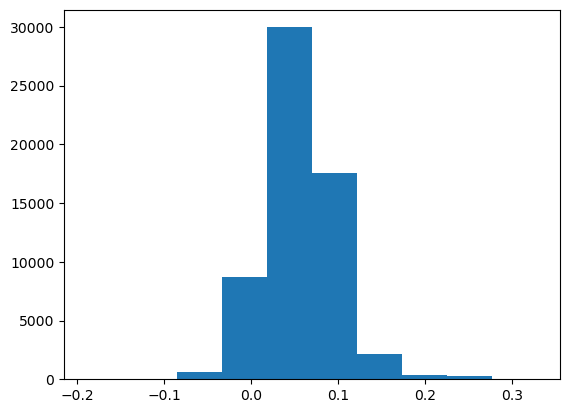

In [47]:
plt.hist(df['Maximum Correlation Value'])

## fisher z transform

In [73]:
def fisher_z_transform(r):
    return np.arctanh(r)
# Apply Fisher's Z transformation to 'Maximum Correlation Value'
df['Max_Corr_Value_Z'] = df['Maximum Correlation Value'].apply(fisher_z_transform)

# # Now, you can group by 'sub', 'ses', and 'roi', then average the transformed values
# # Here we skip averaging the 'Time Lag (s)' since Fisher's Z is not applied to it
# avg_per_ses = df.groupby(['sub', 'ses', 'roi'])['Max_Corr_Value_Z'].mean().reset_index()

# # If needed, apply the inverse Fisher's Z transformation to interpret the averages
# avg_per_ses['Avg_Max_Corr_Value'] = np.tanh(avg_per_ses['Max_Corr_Value_Z'])


In [74]:
# create summary stats
# df_grouped_1 = combined_df.groupby(['sub', 'ses', 'run', 'roi']).mean().reset_index()combined_df

avg_per_ses = df.groupby(['sub', 'ses', 'roi']).median().reset_index()
avg_per_sub = avg_per_ses.groupby(['sub', 'roi']).median().reset_index()
group_level_avg = avg_per_sub.groupby('roi').median().reset_index()
group_level_avg['Avg_Max_Corr_Value'] = np.tanh(group_level_avg['Max_Corr_Value_Z'])


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_11700/176678747.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_per_ses = df.groupby(['sub', 'ses', 'roi']).median().reset_index()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_11700/176678747.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_per_sub = avg_per_ses.groupby(['sub', 'roi']).median().reset_index()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_11700/176678747.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will d

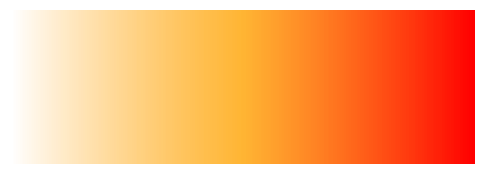

In [88]:
# Define the colors at specific points
colors = [
    # (-1, "#120041"),  # Start with blue at -1.9
    # (-0.8, "#2500fa"),
    # (-0.6, "#84c6fd"),  # Start with blue at -1.9
    (0, "white"),    # Transition to white at 0
    (0.04, "#d50044"),
    (0.05, "#ff0000"),    # Start transitioning to red just after 0 towards 1.2
    (0.064, "#ffd400")  # End with yellow at 1.2
]

colors_with_opacity = [
    # (-1, to_rgba("#3661ab", alpha=1.0)),  # Fully opaque
    # (-0.8, to_rgba("#63a4ff", alpha=0.8)),  # Fully opaque
    # # (-0.1, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0, to_rgba("white", alpha=1.0)),       # Fully opaque
    # (0.1, to_rgba("#d50044", alpha=0.6)),   # 30% opacity
    (1.05, to_rgba("#ffa300", alpha=0.8)),   # 60% opacity
    (0.064, to_rgba("#ff0000", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(0, .064, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
xcorr_cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=xcorr_cmap)
ax.set_axis_off()

plt.show()


In [78]:
sd

0.006185211174874247

In [79]:
maxval

0.06978314285657038

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


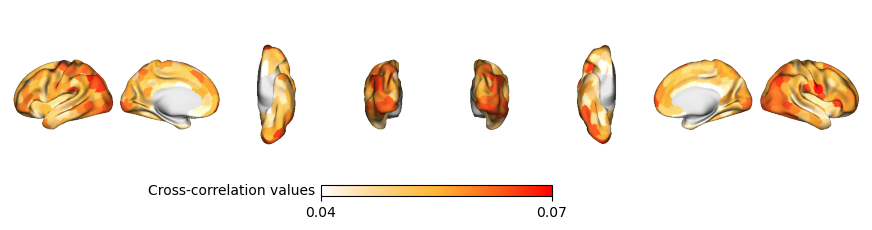

In [90]:
# xcorr_fname = 
# group_level_avg  =pd.read_csv(xcorr_fname, '\t')

schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')
roi_xcorr = group_level_avg['Avg_Max_Corr_Value']
roidata = parc.inverse_transform(roi_xcorr)

maxval = np.max(roi_xcorr);    minval = np.min(roi_xcorr); sd = np.std(roi_xcorr)
plot_brain_surfaces(image=roidata, cbar_label='Cross-correlation values', cmap=xcorr_cmap, color_range=(0.04,0.07))
plt.show()

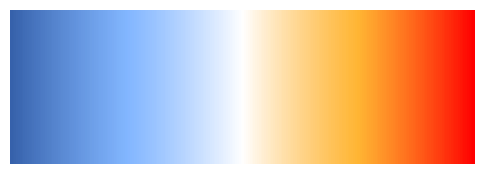

In [71]:
# Define the colors at specific points
colors = [
    (-5.4, "#120041"),  # Start with blue at -1.9
    (-3.6, "#2500fa"),
    (-1.8, "#84c6fd"),  # Start with blue at -1.9
    (0, "white"),    # Transition to white at 0
    (0.7, "#d50044"),
    (1.4, "#ff0000"),    # Start transitioning to red just after 0 towards 1.2
    (2.1, "#ffd400")  # End with yellow at 1.2
]

colors_with_opacity = [
    (-5.4, to_rgba("#3661ab", alpha=1.0)),  # Fully opaque
    (-3.6, to_rgba("#63a4ff", alpha=0.8)),  # Fully opaque
    # (-0.1, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0, to_rgba("white", alpha=1.0)),       # Fully opaque
    # (0.1, to_rgba("#d50044", alpha=0.6)),   # 30% opacity
    (1.4, to_rgba("#ffa300", alpha=0.8)),   # 60% opacity
    (2.1, to_rgba("#ff0000", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(-5.4, 2.1, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()

plt.show()


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


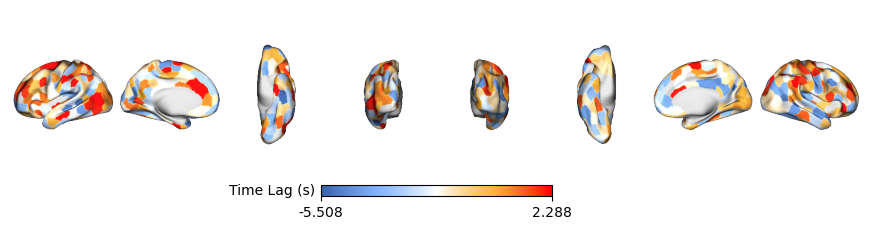

In [72]:
# xcorr_fname = 
# group_level_avg  =pd.read_csv(xcorr_fname, '\t')

schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')
roi_timelag = group_level_avg['Time Lag (s)']
roidata = parc.inverse_transform(roi_timelag)

maxval = np.max(roi_timelag);    minval = np.min(roi_timelag); sd = np.std(roi_timelag)
plot_brain_surfaces(image=roidata, cbar_label='Time Lag (s)', cmap=cmap, color_range=(minval+sd, maxval-sd))
plt.show()